#### Cross-validation

So far, we evaluated the generalization performance of our machine learning algorithms by splitting the data into train and test sets. The idea is to use the train set to fit our estimators and the test one at the end to evaluate them. The only exception is grid search that “fits” the hyperparameters using this test set. Hence, some information might “leak” from it, and the performance on this set is no longer a valid estimation of the generalization error.

We will now see how to solve this issue using grid search with cross-validation. In this unit, we will start by explaining what cross-validation is and, in the next unit, we will combine this technique with grid search.

#### k-fold cross-validation
The idea behind k-fold cross-validation is to split the train set into 
k
 parts and run the algorithm 
k
 times using 
(
k
−
1
)
 parts to train our estimator and the remaining one to evaluate its performance. In total, there are 
k
 different ways to do that. Hence, we get 
k
 estimations of the generalization performance without using our test set. This may sound abstract, so let’s take an example.

This image illustrates k-fold for 
k
=
4
. In this case, we split the data into four parts, and there are four different ways (four folds) to arrange these parts.

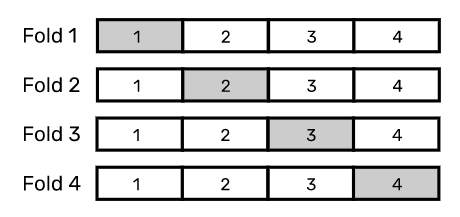

In [1]:
from IPython.display import Image
Image(filename='fold.png')

Each row corresponds to an arrangement of the 
k
 parts into 
(
k
−
1
)
 ones to train our estimator (in white) and one to evaluate it (in gray). Hence, we get four estimations of the generalization performance using the same data.

In practice, we usually apply grid search using this k-fold cross-validation strategy. We evaluate the different combinations of hyperparameters during each fold and select the combination that performs the best in average across all folds. Note that the data in gray is sometimes called the validation set since we use it to validate our hyperparameters.

#### Cross-validation with Scikit-learn
Let’s see how to implement cross-validation

In [2]:
from sklearn import datasets

# Load dataset
iris = datasets.load_iris()

# Create X/y arrays
X = iris["data"]
y = iris["target"]

Scikit-learn implements several cross-validator objects that we can use to perform cross-validation. The KFold one implements the k-fold strategy. We can set the number of folds with the n_splits attribute.

In [3]:
from sklearn.model_selection import KFold

# Create k-fold object
kfold = KFold(n_splits=3)

In our example, we will evaluate the generalization performance of a LogisticRegression() estimator with the one-vs.-rest (OvR) multiclass strategy. Let’s create the estimator

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a logistic regression
logreg = make_pipeline(
    StandardScaler(), LogisticRegression(C=1000, solver="liblinear", multi_class="ovr")
)

We can now apply cross-validation with cross_validate()

In [5]:
from sklearn.model_selection import cross_validate

# Apply cross-validation
scores = cross_validate(logreg, X, y, cv=kfold, return_train_score=True)

# The "scores" variable is a dictionary with the scores
scores.keys()

dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])

The function takes the estimator, the X/y data and our cross-validator object as arguments, and returns a dictionary with the results. Each entry is a list with one value for each fold.

* fit_time - time to fit the estimator
* score_time - time to evaluate the estimator
* train_score - performance on the 
(
k
−
1
)
 parts to train the estimator
* test_score - performance on the remaining “validation set”

Let’s print the train/test scores

In [6]:
print("Train scores:", scores["train_score"])
print("Test scores:", scores["test_score"])


Train scores: [0.98 1.   1.  ]
Test scores: [0. 0. 0.]


We can see that the train scores (accuracy) are close to one, but the test scores are all zero. By default, the KFold object splits the data into k parts without shuffling. This can cause issues when the target values are ordered.

In our case, there are three folds and three categories, each one with the same number of data points. Hence, each fold corresponds to one class. This means that we are always fitting the data on two of the three classes and evaluating it on the other one. Hence, its test score is always zero

In [7]:
# Target variable
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

The KFold object provides a shuffle parameter to shuffle the data before splitting it into k parts. Note that we can set the seed number with the random_state attribute



In [8]:
# Create k-fold object
kfold = KFold(n_splits=3, shuffle=True, random_state=0)

Let’s run the cross_validate() function with this new kfold object

In [9]:
# Apply cross-validation
scores = cross_validate(logreg, X, y, cv=kfold, return_train_score=True)

print("Train scores:", scores["train_score"])
print("Test scores:", scores["test_score"])

Train scores: [0.98 0.96 0.98]
Test scores: [0.98 0.96 0.96]


This time, we get accuracy scores around 97%.

Note that we can also pass an integer value to the cv attribute. In this case, the cross_validate() function automatically creates a k-fold cross-validator object and sets its k value|m

In [11]:
# Apply cross-validation
scores = cross_validate(logreg, X, y, cv=3, return_train_score=True)

print("Train scores:", scores["train_score"])
print("Test scores:", scores["test_score"])

Train scores: [0.95 0.97 0.99]
Test scores: [0.98 0.94 0.94]


By default, it uses a variant of k-fold called stratified k-fold for classification tasks. This strategy ensures that none of the k parts has a category that is under- or over-represented. Hence, we get slightly different accuracy scores in the code from above.

The most commonly used variants are 3, 5 or 10-fold cross-validations. Let’s use the 10-fold one to get a final generalization error estimate for our iris classifier.

In [12]:
import numpy as np

# Apply cross-validation
scores = cross_validate(logreg, X, y, cv=10, return_train_score=True)

# Get train/test scores
train_scores = scores["train_score"]
test_scores = scores["test_score"]

# Print summary
print(
    "Train mean: {:.3f} std: {:.3f}".format(np.mean(train_scores), np.std(train_scores))
)

print("Test mean: {:.3f} std: {:.3f}".format(np.mean(test_scores), np.std(test_scores)))


Train mean: 0.975 std: 0.008
Test mean: 0.960 std: 0.061


As we can see, the test accuracy is around 95% with a standard deviation of 6%.

#### Shuffle split strategy
Note that Scikit-learn implements many other cross-validation strategies. For instance, we can use the ShuffleSplit one which creates 
n
 different train/test sets by shuffling the data. It’s equivalent to applying 
n
 times the train_test_split() function. We can set 
n
 with the n_splits attribute.



In [13]:
from sklearn.model_selection import ShuffleSplit

# Try "shuffle split" strategy
cv_type = ShuffleSplit(n_splits=10, test_size=20, random_state=0)

# Apply cross-validation
scores = cross_validate(logreg, X, y, cv=cv_type, return_train_score=True)

# Test scores
test_scores = scores["test_score"]
print("Test mean: {:.3f} std: {:.3f}".format(np.mean(test_scores), np.std(test_scores)))


Test mean: 0.955 std: 0.052


This time, we get an average test accuracy of 95.5% and a standard deviation of 5.2%.

To get the complete list of cross-validation strategies implemented in Scikit-learn, you can check the Cross validation iterators guide.

#### Summary
In this unit, we learned about cross-validation and saw how to implement it with cross_validate(). In the next unit, we will see how to combine cross-validation and grid search together with GridSearchCV.

